# CH-04 讓 AI 計算技術指標及資料視覺化

## 4-1 技術指標公式太複雜？讓 AI 自動化計算

### 1️⃣ 安裝及匯入套件

In [1]:
!pip install openai
!pip install yfinance -U
from  openai import OpenAI, OpenAIError # 串接 OpenAI API
import yfinance as yf
import pandas as pd # 資料處理套件
import datetime as dt # 時間套件

### 2️⃣ 取得股票資料

In [2]:
# 輸入股票代號
from datetime import datetime
stock_id = "2330.tw"
# 抓取半年資料
end = dt.date.today() # 資料結束時間
start = end - dt.timedelta(days=180) # 資料開始時間
df = yf.download(stock_id, start=start, end=end).reset_index()

print(df)

/tmp/ipykernel_459802/403395175.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed

Price        Date        Close         High          Low         Open  \
Ticker                 2330.TW      2330.TW      2330.TW      2330.TW   
0      2025-04-21   828.159119   840.060807   825.183697   837.085385   
1      2025-04-22   809.314819   822.208315   809.314819   819.232893   
2      2025-04-23   865.847839   865.847839   841.052655   846.011692   
3      2025-04-24   856.921570   878.741332   851.962533   878.741332   
4      2025-04-25   880.724915   893.618410   878.741300   892.626603   
..            ...          ...          ...          ...          ...   
119    2025-10-13  1415.000000  1420.000000  1390.000000  1390.000000   
120    2025-10-14  1425.000000  1460.000000  1420.000000  1455.000000   
121    2025-10-15  1465.000000  1465.000000  1425.000000  1435.000000   
122    2025-10-16  1485.000000  1495.000000  1465.000000  1465.000000   
123    2025-10-17  1450.000000  1465.000000  1450.000000  1455.000000   

Price     Volume  
Ticker   2330.TW  
0       1841

### 3️⃣ 輸入 GEMINI API KEY

In [4]:
#from google.colab import userdata
import os
api_key = os.environ.get('GEMINI_API_KEY')

client = OpenAI(
#    api_key=userdata.get('GEMINI_API_KEY'),
    api_key=api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

### 4️⃣ 創建 Gemini 2.0 Flash 模型函式

In [5]:
def get_reply(messages):
  try:
    response = client.chat.completions.create(model="gemini-2.0-flash", messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply

# 設定 AI 角色, 使其依據使用者需求進行 df 處理
def ai_helper(df, user_msg):

  msg = [{
    "role":
    "system",
    "content":
    f"As a professional code generation robot, \
      I require your assistance in generating Python code \
      based on specific user requirements. To proceed, \
      I will provide you with a dataframe (df) that follows the \
      format {df.columns}. Your task is to carefully analyze the \
      user's requirements and generate the Python code \
      accordingly.Please note that your response should solely \
      consist of the code itself, \
      and no additional information should be included."
  }, {
    "role":
    "user",
    "content":
    f"The user requirement:{user_msg} \n\
       Your task is to develop a Python function named \
      'calculate(df)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {df.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(df)' function \
      and exclude any unrelated content."
  }]

  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```", "")
  cleaned_code = cleaned_code.replace("python", "")

  return cleaned_code

### 讓 AI 自動生成技術指標程式碼

### 5️⃣ 計算移動平均線

In [6]:
code_str = ai_helper(df, "計算8日MA與13日MA ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the 8-day and 13-day moving averages for the 'Close' price of '2330.TW'.

    Args:
        df (pd.DataFrame): A DataFrame with MultiIndex columns.
                           Specifically, it should contain 'Close' price data for '2330.TW'.

    Returns:
        pd.DataFrame: The DataFrame with added columns for the 8-day and 13-day moving averages.
    """
    df[('MA_8', '2330.TW')] = df[('Close', '2330.TW')].rolling(window=8).mean()
    df[('MA_13', '2330.TW')] = df[('Close', '2330.TW')].rolling(window=13).mean()
    return df



Price,Date,Close,High,Low,Open,Volume,MA_8,MA_13
Ticker,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW
119,2025-10-13,1415.0,1420.0,1390.0,1390.0,53850992,1387.50,1361.153846
120,2025-10-14,1425.0,1460.0,1420.0,1455.0,39889256,1402.50,1371.153846
121,2025-10-15,1465.0,1465.0,1425.0,1435.0,41056405,1420.00,1380.769231
122,2025-10-16,1485.0,1495.0,1465.0,1465.0,37737678,1435.00,1391.923077
123,2025-10-17,1450.0,1465.0,1450.0,1455.0,38077331,1441.25,1401.923077


### 6️⃣ 計算 MACD

In [7]:
code_str = ai_helper(df, "先計算 EMA 再計算 MACD, 欄位名稱用 MACD_Histogram 命名")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates EMA and MACD (with MACD Histogram) for the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with 'Close' price data under the '2330.TW' ticker.

    Returns:
        pd.DataFrame: The DataFrame with added 'MACD_Histogram' column.
    """

    close_price = df[('Close', '2330.TW')]

    # Calculate EMA
    ema_12 = close_price.ewm(span=12, adjust=False).mean()
    ema_26 = close_price.ewm(span=26, adjust=False).mean()

    # Calculate MACD
    macd = ema_12 - ema_26

    # Calculate Signal Line (9-day EMA of MACD)
    signal_line = macd.ewm(span=9, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd - signal_line

    # Add MACD Histogram to the DataFrame
    df['MACD_Histogram'] = macd_histogram

    return df



Price,Date,Close,High,Low,Open,Volume,MA_8,MA_13,MACD_Histogram
Ticker,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,
119,2025-10-13,1415.0,1420.0,1390.0,1390.0,53850992,1387.50,1361.153846,8.330076
120,2025-10-14,1425.0,1460.0,1420.0,1455.0,39889256,1402.50,1371.153846,6.637946
121,2025-10-15,1465.0,1465.0,1425.0,1435.0,41056405,1420.00,1380.769231,7.305553
122,2025-10-16,1485.0,1495.0,1465.0,1465.0,37737678,1435.00,1391.923077,8.124198
123,2025-10-17,1450.0,1465.0,1450.0,1455.0,38077331,1441.25,1401.923077,5.466107


### 7️⃣ 計算 RSI

In [8]:
code_str = ai_helper(df, "計算 RSI ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the Relative Strength Index (RSI) for the given dataframe.

    Args:
        df (pd.DataFrame): A dataframe containing closing prices.
                           The dataframe must have a MultiIndex with 'Close' and ticker.

    Returns:
        pd.DataFrame: The dataframe with an additional 'RSI' column.
    """
    close_prices = df[('Close', '2330.TW')]
    delta = close_prices.diff()
    delta = delta[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    window = 14
    
    avg_gain = up.rolling(window=window).mean()
    avg_loss = abs(down.rolling(window=window).mean())

    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    rsi_series = pd.Series(rsi, index=close_prices.index[window:])
    
    df[('RSI', '2330.TW')] = pd.Series(index=df.index)
    df.loc[rsi_series.index, ('RSI', '2330.TW')] = rsi_series

    return df



Price,Date,Close,High,Low,Open,Volume,MA_8,MA_13,MACD_Histogram,RSI
Ticker,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,2330.TW
119,2025-10-13,1415.0,1420.0,1390.0,1390.0,53850992,1387.50,1361.153846,8.330076,69.117647
120,2025-10-14,1425.0,1460.0,1420.0,1455.0,39889256,1402.50,1371.153846,6.637946,74.242424
121,2025-10-15,1465.0,1465.0,1425.0,1435.0,41056405,1420.00,1380.769231,7.305553,75.000000
122,2025-10-16,1485.0,1495.0,1465.0,1465.0,37737678,1435.00,1391.923077,8.124198,73.015873
123,2025-10-17,1450.0,1465.0,1450.0,1455.0,38077331,1441.25,1401.923077,5.466107,65.714286


### 8️⃣ 計算布林通道

In [9]:
code_str = ai_helper(df, "請計算1.5個標準差的布林通道, 欄位以 Upper_Band 和 Lower_Band 命名")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    df['Upper_Band'] = df[('MA_13', '2330.TW')] + 1.5 * df[('Close', '2330.TW')].rolling(window=20).std()
    df['Lower_Band'] = df[('MA_13', '2330.TW')] - 1.5 * df[('Close', '2330.TW')].rolling(window=20).std()
    return df



Price,Date,Close,High,Low,Open,Volume,MA_8,MA_13,MACD_Histogram,RSI,Upper_Band,Lower_Band
Ticker,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,2330.TW,,
119,2025-10-13,1415.0,1420.0,1390.0,1390.0,53850992,1387.50,1361.153846,8.330076,69.117647,1458.818843,1263.488849
120,2025-10-14,1425.0,1460.0,1420.0,1455.0,39889256,1402.50,1371.153846,6.637946,74.242424,1468.537313,1273.770379
121,2025-10-15,1465.0,1465.0,1425.0,1435.0,41056405,1420.00,1380.769231,7.305553,75.000000,1482.826684,1278.711778
122,2025-10-16,1485.0,1495.0,1465.0,1465.0,37737678,1435.00,1391.923077,8.124198,73.015873,1498.024676,1285.821478
123,2025-10-17,1450.0,1465.0,1450.0,1455.0,38077331,1441.25,1401.923077,5.466107,65.714286,1508.497967,1295.348187


### 9️⃣ 能量潮指標 (On-Balance Volumem, OBV)

In [10]:
import numpy as np
code_str = ai_helper(df, "計算 OBV 指標")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculate the On Balance Volume (OBV) indicator.

    Args:
        df (pd.DataFrame): A DataFrame with 'Close' and 'Volume' columns.

    Returns:
        pd.DataFrame: The DataFrame with the OBV column added.
    """
    close = df[('Close', '2330.TW')]
    volume = df[('Volume', '2330.TW')]
    obv = pd.Series(0.0, index=df.index)

    for i in range(1, len(df)):
        if close.iloc[i] > close.iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] + volume.iloc[i]
        elif close.iloc[i] < close.iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] - volume.iloc[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]

    df[('OBV', '2330.TW')] = obv
    return df



Price,Date,Close,High,Low,Open,Volume,MA_8,MA_13,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
Ticker,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,2330.TW,,,2330.TW
119,2025-10-13,1415.0,1420.0,1390.0,1390.0,53850992,1387.50,1361.153846,8.330076,69.117647,1458.818843,1263.488849,9.184344e+08
120,2025-10-14,1425.0,1460.0,1420.0,1455.0,39889256,1402.50,1371.153846,6.637946,74.242424,1468.537313,1273.770379,9.583236e+08
121,2025-10-15,1465.0,1465.0,1425.0,1435.0,41056405,1420.00,1380.769231,7.305553,75.000000,1482.826684,1278.711778,9.993800e+08
122,2025-10-16,1485.0,1495.0,1465.0,1465.0,37737678,1435.00,1391.923077,8.124198,73.015873,1498.024676,1285.821478,1.037118e+09
123,2025-10-17,1450.0,1465.0,1450.0,1455.0,38077331,1441.25,1401.923077,5.466107,65.714286,1508.497967,1295.348187,9.990404e+08


### 讓 AI 自動統整 Dataframe

### 🔟 將日頻資料轉換成月頻資料

In [11]:
code_str = ai_helper(df, "請將日K線的資料轉換成月K線 ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = df
df_monthly = new_df
df_monthly = calculate(df_monthly)
df_monthly.tail()


import pandas as pd

def calculate(df):
    """
    Converts daily candlestick data to monthly candlestick data.

    Args:
        df (pd.DataFrame): A DataFrame with a MultiIndex as described in the prompt.

    Returns:
        pd.DataFrame: A DataFrame containing monthly candlestick data.
    """

    df_monthly = df.copy()
    df_monthly.index = pd.to_datetime(df_monthly.index)
    
    ohlc = {
        ('Open', '2330.TW'): 'first',
        ('High', '2330.TW'): 'max',
        ('Low', '2330.TW'): 'min',
        ('Close', '2330.TW'): 'last',
        ('Volume', '2330.TW'): 'sum',
        ('MA_8', '2330.TW'): 'last',
        ('MA_13', '2330.TW'): 'last',
        ('MACD_Histogram', ''): 'last',
        ('RSI', '2330.TW'): 'last',
        ('Upper_Band', ''): 'last',
        ('Lower_Band', ''): 'last',
        ('OBV', '2330.TW'): 'last'
    }

    df_monthly = df_monthly.resample('M').agg(ohlc)
    df_monthly.dropna(subset=[('Open', '2330.TW')], inplace=True)

    return df_monthly



<string>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


Price,Open,High,Low,Close,Volume,MA_8,MA_13,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
Ticker,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,2330.TW,,,2330.TW
1970-01-31,837.085385,1495.0,809.314819,1450.0,3800691366,1441.25,1401.923077,5.466107,65.714286,1508.497967,1295.348187,999040359.0


## 4-2 資料視覺化

### 1️⃣1️⃣ 安裝及匯入套件

In [12]:
import matplotlib.pyplot as plt

### 畫出簡易股價圖

### 1️⃣2️⃣ 讓我們再一次檢視資料格式吧！

In [13]:
new_df = new_df.reset_index() # 重設 index
new_df['Date'] = pd.to_datetime(new_df['Date']) # 將 Date 轉換為 datetime 類別
new_df.tail()

Price,index,Date,Close,High,Low,Open,Volume,MA_8,MA_13,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
Ticker,,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,2330.TW,,,2330.TW
119,119,2025-10-13,1415.0,1420.0,1390.0,1390.0,53850992,1387.50,1361.153846,8.330076,69.117647,1458.818843,1263.488849,9.184344e+08
120,120,2025-10-14,1425.0,1460.0,1420.0,1455.0,39889256,1402.50,1371.153846,6.637946,74.242424,1468.537313,1273.770379,9.583236e+08
121,121,2025-10-15,1465.0,1465.0,1425.0,1435.0,41056405,1420.00,1380.769231,7.305553,75.000000,1482.826684,1278.711778,9.993800e+08
122,122,2025-10-16,1485.0,1495.0,1465.0,1465.0,37737678,1435.00,1391.923077,8.124198,73.015873,1498.024676,1285.821478,1.037118e+09
123,123,2025-10-17,1450.0,1465.0,1450.0,1455.0,38077331,1441.25,1401.923077,5.466107,65.714286,1508.497967,1295.348187,9.990404e+08


### 1️⃣3️⃣ 使用 matplotlib 畫出收盤價的折線圖

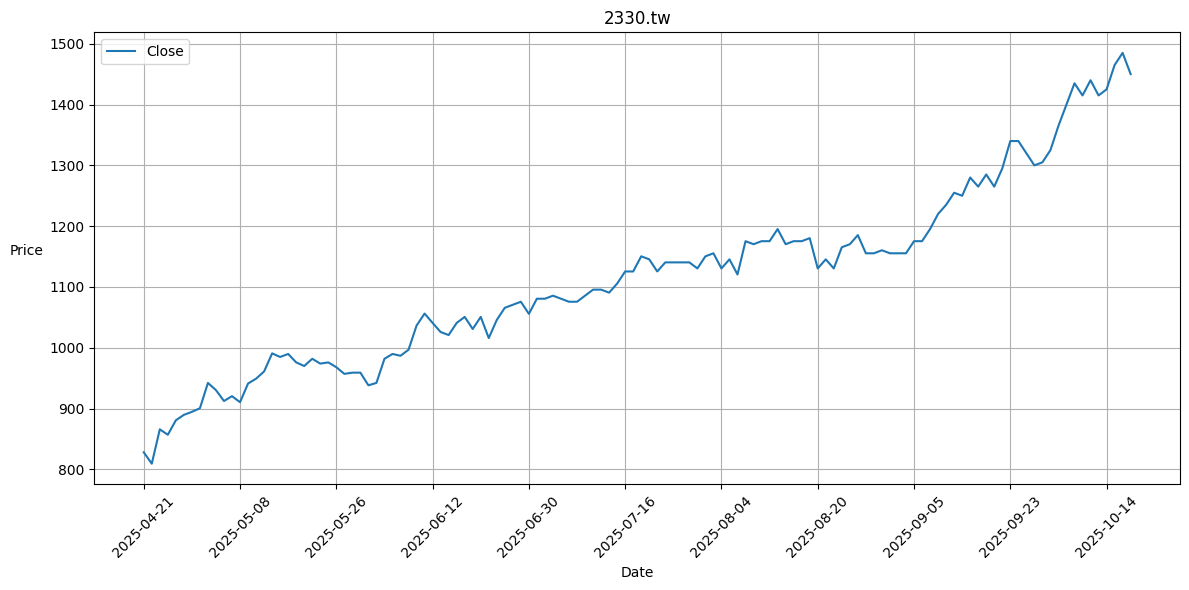

In [14]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 6))

# 設定要繪製的資料欄位
plt.plot(new_df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num], rotation = 45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price', rotation=0, ha='right')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()

# 顯示圖表
plt.show()

### 1️⃣4️⃣ 加入成交量

In [28]:
!pip install matplotlib==3.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 1.8 MB/s  0:00:04a 0:00:01m eta 0:00:010m
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.7
    Uninstalling matplotlib-3.10.7:
      Successfully uninstalled matplotlib-3.10.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
descript-audiotools-unofficial 0.7.4 requires protobuf!=4.24.0,<5.0.0,>=3.19.6, but you have protobuf 6.33.0 which is incompatible.
parler-tts 0.2.3 requires transformers<=4.46.1,>=4.46.1, but you have transformers 4.57.1 which is incompatible.
inference 0.58.2 requires filelock<=3.17.0,>=3.12.0, but you have filelock 3.20.0 which is incompatible.
inference 0.58.2 requires numpy<2.3.0,>=2.0.0, but you have numpy 2.3.4 which is incompatible.
inference 0.58.2 requires tokenizers<0.22.0,>=0.19.0, but you have tokenizers 0.22.1 which is incompatible.
infe

In [29]:
import matplotlib.pyplot as plt

TypeError: only length-1 arrays can be converted to Python scalars

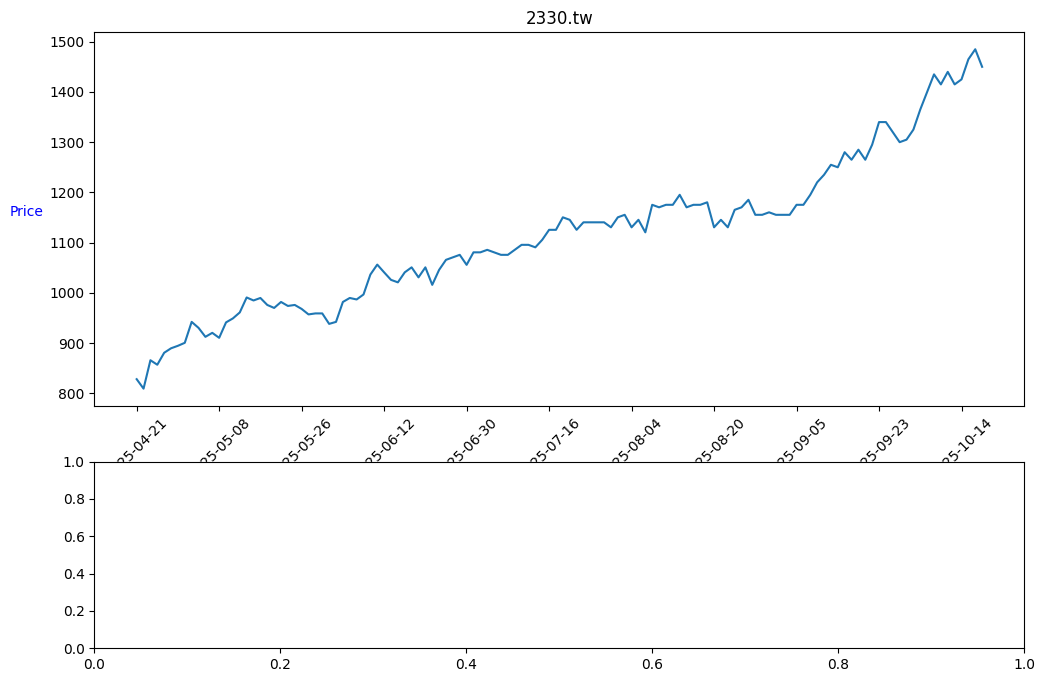

In [30]:
# 創建兩張子圖
fig, (ax1, ax2) = plt.subplots(2, 1,
                figsize=(12, 8),
                gridspec_kw={'height_ratios': [2, 1]})

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num], rotation=45)

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'],  color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')
ax2.set_xticks([]) # 不顯示日期標籤
# 若要顯示圖表標籤可以使用以下程式碼
# ax2.set_xticks(date[::len(date)//num].index)
# ax2.set_xticklabels(date[::len(date)//num], rotation=45)

# 讓子圖填充、對齊
plt.tight_layout()

# 顯示圖表
plt.show()


### 1️⃣5️⃣ 加入技術指標

In [ ]:
# 創建三個子圖
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                    figsize=(12, 8),
                    gridspec_kw={'height_ratios': [2, 1, 1]},
                    sharex=True)

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
# 加入布林通道
ax1.plot(new_df['Upper_Band'], alpha=0.5) # alpha 設定透明度
ax1.plot(new_df['Lower_Band'], alpha=0.5)
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num])

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'], alpha=0.5, color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')

# 繪製技術指標
ax3.bar(new_df.index, new_df['MACD_Histogram'], alpha=0.5, color='red')
ax3.set_ylabel('MACD', color='red', rotation=0, ha='right')

# 調整子圖間的距離
plt.tight_layout()

# 顯示圖表
plt.show()

### 繪製 K 線圖：mplfinance

### 1️⃣6️⃣ 匯入技術分析繪圖套件

In [ ]:
!pip install mplfinance
import mplfinance as mpf

### 1️⃣7️⃣ 選擇資料時間

In [ ]:
kplot_df = new_df.set_index('Date')
#kplot_df = kplot_df['2024-02-01':'2024-07-29']
kplot_df.tail()

### 1️⃣8️⃣ 用 mplfinance 繪製 K 線圖

In [ ]:
mpf.plot(kplot_df, type='candle', title=f'{stock_id}')

### 1️⃣9️⃣ 加入繪圖設定

In [ ]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)
# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}')

### 2️⃣0️⃣ 加入子圖

In [ ]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo',
                marketcolors=my_color)

# 交易量和技術指標子圖
ap = [
    # 上軌線
    mpf.make_addplot(kplot_df['Upper_Band'], color='red',
                      alpha=0.5, linestyle='--'),
    # 下軌線
    mpf.make_addplot(kplot_df['Lower_Band'], color='red',
                     alpha=0.5, linestyle='--'),
    # 成交量
    mpf.make_addplot(kplot_df['Volume'], panel=1, type='bar',
                     color='g', alpha=0.5, ylabel='Volume'),
    # MACD
    mpf.make_addplot(kplot_df['MACD_Histogram'], panel=2, type='bar',
                     color='r', alpha=0.5, ylabel='MACD')
]

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', addplot=ap,
          style=my_style, title=f'{stock_id}')

## 4-3 plotly 互動式圖表

### 2️⃣1️⃣ 檢視資料

In [ ]:
bk_df = new_df
bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')
bk_df.tail()

### 2️⃣2️⃣ 匯入 plotly 套件

In [ ]:
import plotly.graph_objects as go

### 2️⃣3️⃣ 繪製互動式 K 線圖

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 顯示圖表
fig.show()

### 2️⃣4️⃣ 移除非交易日空值
解決繪圖不連續問題

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 移除非交易日空值
# 生成該日期範圍內的所有日期
all_dates = pd.date_range(start=bk_df.index.min(),
              end=bk_df.index.max())
# 找出不在資料中的日期
breaks = all_dates[~all_dates.isin(bk_df.index)]
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

# 顯示圖表
fig.show()

### 2️⃣5️⃣ 加入懸停十字軸

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])


# 圖表更新-加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_layout(
    height=800,
    width=1200
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

### 2️⃣6️⃣ 加入技術指標

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red', decreasing_line_color='green',
            name = "K 線")])


# 布林通道
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Upper_Band'],mode='lines',
    line={'color': 'green','dash': 'dash'},name = "上軌線"))
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Lower_Band'], mode='lines',
    line={'color': 'green', 'dash': 'dash'},name = "下軌線"))

# 交易量
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['Volume'], marker={'color': 'green'},
      yaxis='y2', name = "交易量"))

# MACD
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['MACD_Histogram'], marker={'color': 'red'},
      yaxis='y3', name = "MACD"))

# 加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="toaxis")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")

# 更新畫布大小並增加範圍選擇
fig.update_layout(
    height=800,
    yaxis={'domain': [0.35, 1]},
    yaxis2={'domain': [0.15, 0.3]},
    yaxis3={'domain': [0, 0.15]},
    title=f"{stock_id}",
    xaxis={
        # 範圍選擇格
        'rangeselector': {
            'buttons': [
                {'count': 1, 'label': '1M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 6, 'label': '6M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 1, 'label': '1Y',
                  'step': 'year', 'stepmode': 'backward'},
                {'step': 'all'}
            ]
        },
        # 範圍滑動條
        'rangeslider': {
            'visible': True,
            # 滑動條的高度 (設置 0.01 就會變單純的 bar)
            'thickness': 0.01,
            'bgcolor': "#E4E4E4"  # 背景色
        },
        'type': 'date'
    }
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

### 2️⃣7️⃣ 寫成函式

In [ ]:
# 下載資料並讓 AI 計算指標
def download_stock_data(stock_id, start=None,
                        end=None, indicator='MACD'):
    stock_id = f"{stock_id}.tw"
    if not end:
        end = dt.date.today()
    if not start:
        start = end - dt.timedelta(days=365)
    # 從 yf 下載資料
    df = yf.download(stock_id, start=start, end=end).reset_index()

    # AI 計算技術指標
    code_str = ai_helper(df, f"計算{indicator}")
    code_str=code_str.replace('```','')
    code_str=code_str.replace('python','')
    print(code_str)

    # 將 exec 生成的 calculate 設為局部變數
    local_vars = {}
    exec(code_str, globals(), local_vars)
    calculate = local_vars['calculate']

    df = calculate(df)

    # 資料處理
    bk_df = df.reset_index()
    bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')

    return bk_df

# 繪製圖表函式
def create_stock_figure(stock_id, bk_df):

    # 創建 K 線圖
    fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
                        open=bk_df['Open'],
                        high=bk_df['High'],
                        low=bk_df['Low'],
                        close=bk_df['Close'],
                        increasing_line_color='red',
                        decreasing_line_color='green',
                        name = "K 線")])

    # 交易量
    fig.add_trace(go.Bar(x=bk_df.index, y=bk_df['Volume'],
                         marker={'color': 'green'}, yaxis='y2',
                           name = "交易量"))

    # 找出需要繪製的欄位
    columns = bk_df.columns
    exclude_columns = ['index','Date', 'Open', 'High',
                        'Low', 'Close', 'Adj Close', 'Volume']
    remain_columns = [col for col in columns if
                       col not in exclude_columns]
    min_close = bk_df['Close'].min() - bk_df['Close'].std()
    max_close = bk_df['Close'].max() + bk_df['Close'].std()
    # 繪製技術指標
    for i in remain_columns:
      if min_close <= bk_df[i].mean() <= max_close:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', name=i))
      else:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', yaxis='y3', name=i))

    # 加入懸停十字軸
    fig.update_xaxes(showspikes=True, spikecolor="gray",
                    spikemode="toaxis")
    fig.update_yaxes(showspikes=True, spikecolor="gray",
                    spikemode="across")
    # 更新畫布大小並增加範圍選擇
    fig.update_layout(
        height=800,
        width=1200,
        yaxis={'domain': [0.35, 1]},
        yaxis2={'domain': [0.15, 0.3]},
        # 若要重疊 y1 和 y3, 可以改成
        # yaxis3=dict(overlaying='y', side='right')
        yaxis3={'domain': [0, 0.15]},
        title=f"{stock_id}",
        xaxis={
            # 範圍選擇格
            'rangeselector': {
                'buttons': [
                    {'count': 1, 'label': '1M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 6, 'label': '6M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 1, 'label': '1Y',
                      'step': 'year', 'stepmode': 'backward'},
                    {'step': 'all'}
                ]
            },
            # 範圍滑動條
            'rangeslider': {
                'visible': True,
                'thickness': 0.01,  # 滑動條的高度
                'bgcolor': "#E4E4E4"  # 背景色
            },
            'type': 'date'
        }
    )

    # 移除非交易日空值
    # 生成該日期範圍內的所有日期
    all_dates = pd.date_range(start=bk_df.index.min(),
                               end=bk_df.index.max())
    # 找出不在資料中的日期
    breaks = all_dates[~all_dates.isin(bk_df.index)]
    dt_breaks = breaks.tolist() # 轉換成列表格式
    fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

    return fig

# 主函式
def plotly_stock(stock_id, start=None, end=None, indicator='MACD'):

  df = download_stock_data(stock_id, start, end, indicator)
  fig = create_stock_figure(stock_id,df)
  fig.show()

### 2️⃣8️⃣ 執行函式

In [ ]:
plotly_stock("2317", start='2022-01-01', end= None,
             indicator='布林通道 及 MACD')